# Comparing Models on an Incorrect Sample

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to Cuda

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Get Test Data and Sub Labels

In [3]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [4]:
# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

# sub labels
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

In [5]:
def get_sample(idx):
    return test_images[idx], test_labels[idx], test_horizontal_image_labels[idx].reshape(28, 28), test_vertical_image_labels[idx].reshape(28, 28)

## Load Models

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal processing
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical processing
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # classification
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

In [7]:
main_quest_model = NeuralNetwork().to(device)
main_quest_model.load_state_dict(torch.load("./main_quest.pth"))

side_quest_model = NeuralNetwork().to(device)
side_quest_model.load_state_dict(torch.load("./side_quests.pth"))

partial_side_quest_model = NeuralNetwork().to(device)
partial_side_quest_model.load_state_dict(torch.load("./partial_side_quests.pth"))

<All keys matched successfully>

## Comparing Layer Weights Across Models

### Horizontal Weights

In [8]:
main_h_weights = np.abs(main_quest_model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
side_h_weights = np.abs(side_quest_model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
partial_h_weights = np.abs(partial_side_quest_model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

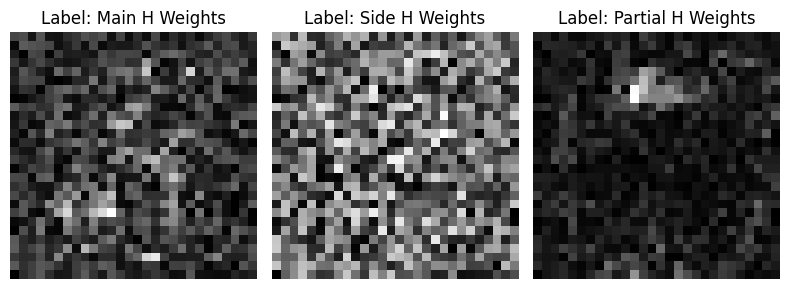

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(main_h_weights, "Main H Weights", ax=axes[0])
visualize_image(side_h_weights, "Side H Weights", ax=axes[1])
visualize_image(partial_h_weights, "Partial H Weights", ax=axes[2])

plt.tight_layout()
plt.show()

### Vertical Weights

In [10]:
main_v_weights = np.abs(main_quest_model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
side_v_weights = np.abs(side_quest_model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
partial_v_weights = np.abs(partial_side_quest_model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

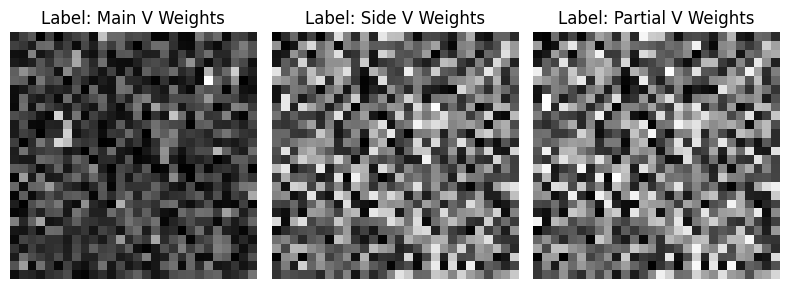

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(main_v_weights, "Main V Weights", ax=axes[0])
visualize_image(side_v_weights, "Side V Weights", ax=axes[1])
visualize_image(partial_v_weights, "Partial V Weights", ax=axes[2])

plt.tight_layout()
plt.show()

### Classifcation Weights

In [12]:
main_c_weights = np.abs(main_quest_model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
side_c_weights = np.abs(side_quest_model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
partial_c_weights = np.abs(partial_side_quest_model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

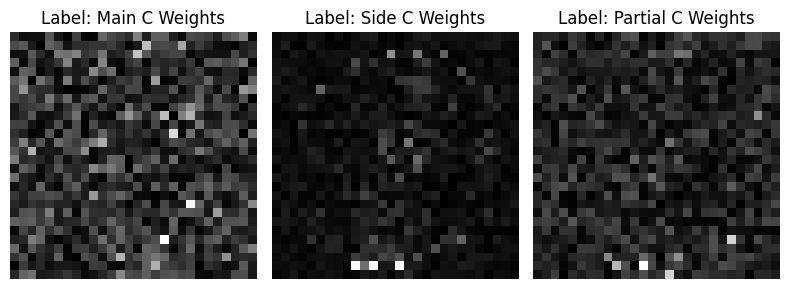

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(main_c_weights, "Main C Weights", ax=axes[0])
visualize_image(side_c_weights, "Side C Weights", ax=axes[1])
visualize_image(partial_c_weights, "Partial C Weights", ax=axes[2])

plt.tight_layout()
plt.show()

## Activation and Sample Exploration

In [14]:
def convert_tensor_to_np_arr(img_tensor):
    return np.abs(img_tensor.clone().reshape(28, 28).detach().cpu().numpy())

In [15]:
def convert_numpy_image_to_tensor(img):
    """
    """
    return torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')

In [16]:
main_quest_model.eval()
side_quest_model.eval()
partial_side_quest_model.eval()

with torch.no_grad():
    for idx, test_img in enumerate(test_images):
        img_tensor = convert_numpy_image_to_tensor(test_img)
        
        out, v_act, h_act = main_quest_model(img_tensor)
        s_out, s_v_act, s_h_act = side_quest_model(img_tensor)
        p_out, p_v_act, p_h_act = partial_side_quest_model(img_tensor)

        if torch.max(s_out, 1)[1].item() != test_labels[idx]:
            break

In [17]:
print(f"On sample {idx}:")
print(f"\tMain answer: {torch.max(out, 1)[1].item()}")
print(f"\tSide answer: {torch.max(s_out, 1)[1].item()}")
print(f"\tPartial answer: {torch.max(p_out, 1)[1].item()}")
print(f"\tActual answer: {test_labels[idx]}")

On sample 7:
	Main answer: 9
	Side answer: 5
	Partial answer: 4
	Actual answer: 9


In [18]:
print(out)

tensor([[-3.2986, -4.1952, -2.6720,  2.0146,  1.9358,  0.9857, -6.1000,  0.6880,
          0.1312,  9.8927]], device='cuda:0')


In [19]:
print(s_out)

tensor([[ 14.7536,  12.2643,  24.0721,  36.4830,  73.6210,  79.4904,  58.3416,
         -40.2673,  77.3572,  70.8833]], device='cuda:0')


In [20]:
print(p_out)

tensor([[-13.1417,  19.4047,  17.0103,  27.0577,  74.5998,  56.0716,  39.2448,
          41.1608,  26.0978,  70.5604]], device='cuda:0')


### Horizontal Activation Example

In [21]:
h_act_img = convert_tensor_to_np_arr(h_act)
s_h_act_img = convert_tensor_to_np_arr(s_h_act)
p_h_act_img = convert_tensor_to_np_arr(p_h_act)

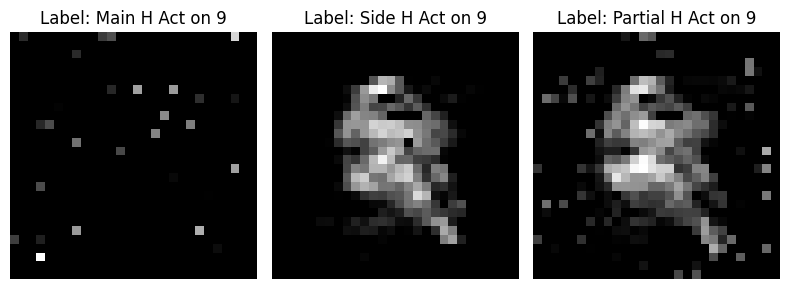

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

label = 9
visualize_image(h_act_img, f"Main H Act on {label}", ax=axes[0])
visualize_image(s_h_act_img, f"Side H Act on {label}", ax=axes[1])
visualize_image(p_h_act_img, f"Partial H Act on {label}", ax=axes[2])

plt.tight_layout()
plt.show()

### Vertical Activation Example

In [23]:
v_act_img = convert_tensor_to_np_arr(v_act)
s_v_act_img = convert_tensor_to_np_arr(s_v_act)
p_v_act_img = convert_tensor_to_np_arr(p_v_act)

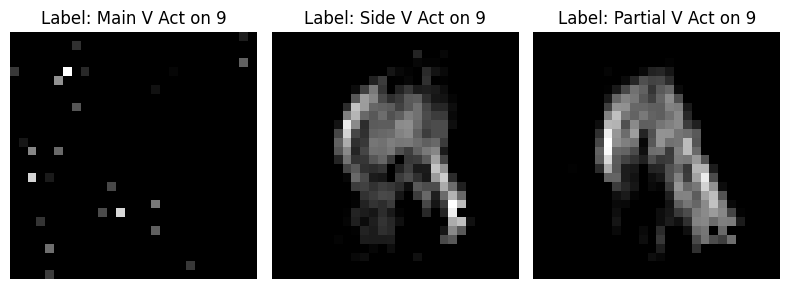

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(v_act_img, f"Main V Act on {label}", ax=axes[0])
visualize_image(s_v_act_img, f"Side V Act on {label}", ax=axes[1])
visualize_image(p_v_act_img, f"Partial V Act on {label}", ax=axes[2])

plt.tight_layout()
plt.show()

## Failure Analysis

In [25]:
main_quest_model.eval()
side_quest_model.eval()
partial_side_quest_model.eval()

main_quest_dict = {}
side_quest_dict = {}
partial_quest_dict = {}
with torch.no_grad():
    for idx, test_img in enumerate(test_images):
        img_tensor = convert_numpy_image_to_tensor(test_img)
        
        out, v_act, h_act = main_quest_model(img_tensor)
        s_out, s_v_act, s_h_act = side_quest_model(img_tensor)
        p_out, p_v_act, p_h_act = partial_side_quest_model(img_tensor)

        expected = test_labels[idx]
        if torch.max(out, 1)[1].item() != expected:
            if expected in main_quest_dict:
                main_quest_dict[expected] += 1
            else:
                main_quest_dict[expected] = 1

        if torch.max(s_out, 1)[1].item() != expected:
            if expected in side_quest_dict:
                side_quest_dict[expected] += 1
            else:
                side_quest_dict[expected] = 1

        if torch.max(p_out, 1)[1].item() != expected:
            if expected in partial_quest_dict:
                partial_quest_dict[expected] += 1
            else:
                partial_quest_dict[expected] = 1

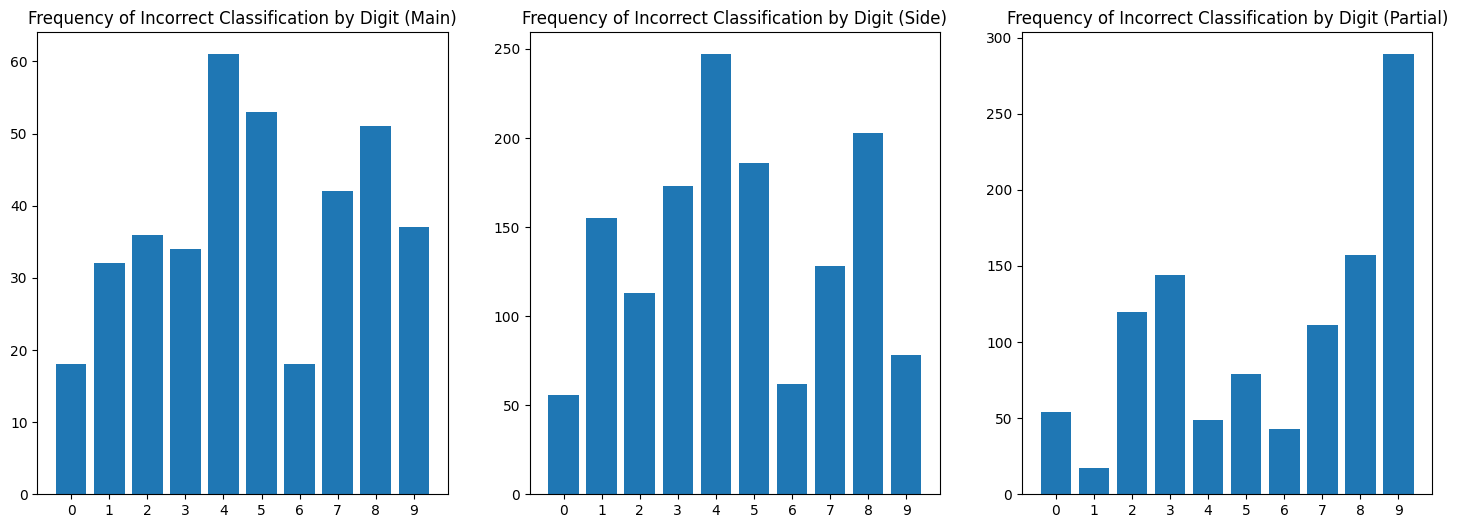

In [58]:
plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 3, 1)
bars1 = ax1.bar(main_quest_dict.keys(), main_quest_dict.values())
ax1.set_xticks(range(len(main_quest_dict)))
ax1.set_title("Frequency of Incorrect Classification by Digit (Main)")

ax2 = plt.subplot(1, 3, 2)
bars2 = ax2.bar(side_quest_dict.keys(), side_quest_dict.values())
ax2.set_xticks(range(len(side_quest_dict)))
ax2.set_title("Frequency of Incorrect Classification by Digit (Side)")

ax3 = plt.subplot(1, 3, 3)
bars3 = ax3.bar(partial_quest_dict.keys(), partial_quest_dict.values())
ax3.set_xticks(range(len(partial_quest_dict)))
ax3.set_title("Frequency of Incorrect Classification by Digit (Partial)")

plt.show()

From this exercise, it does seem to me that the main quest is indead noisy/random in its weights and activations. Also, vertical edges might be more important as an intermediate feature than horizontal ones? Still a little early to declare that. Could simply be ordering of the layers...

It is interesting that the incorrect answers on the side quest appear porportional to the main quest, while the partial quest is completely different in what it struggles with. So, we were heading in the right direction, but never hit the more optimal main quest solution b/c of oscillations in pursuing side quests? This is assuming that the path travelled maintains this proportionality - it could just be a random position in the function that happens to have yielded this pattern.

I wonder if the introduction of a curve/contour detection layer would help...